# Use Soft Actor-Critic with Auto $\alpha$ Tuning to Play LunarLanderContinuous-v2

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make("LunarLanderContinuous-v2")
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

08:18:11 [INFO] env: <LunarLanderContinuous<LunarLanderContinuous-v2>>
08:18:11 [INFO] action_space: Box(-1.0, 1.0, (2,), float32)
08:18:11 [INFO] observation_space: Box(-inf, inf, (8,), float32)
08:18:11 [INFO] reward_range: (-inf, inf)
08:18:11 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
08:18:11 [INFO] _max_episode_steps: 1000
08:18:11 [INFO] _elapsed_steps: None
08:18:11 [INFO] id: LunarLanderContinuous-v2
08:18:11 [INFO] entry_point: gym.envs.box2d:LunarLanderContinuous
08:18:11 [INFO] reward_threshold: 200
08:18:11 [INFO] nondeterministic: False
08:18:11 [INFO] max_episode_steps: 1000
08:18:11 [INFO] _kwargs: {}
08:18:11 [INFO] _env_name: LunarLanderContinuous


In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'done'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = args
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class SACAgent:
    def __init__(self, env):
        state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_low = env.action_space.low
        self.action_high = env.action_space.high
        self.gamma = 0.99

        self.replayer = DQNReplayer(100000)

        # create alpha
        self.target_entropy = -self.action_dim
        self.ln_alpha_tensor = torch.zeros(1, requires_grad=True)
        self.alpha_optimizer = optim.Adam([self.ln_alpha_tensor,], lr=0.0003)

        # create actor
        self.actor_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256], output_size=self.action_dim*2,
                output_activator=nn.Tanh())
        self.actor_optimizier = optim.Adam(self.actor_net.parameters(), lr=0.0003)

        # create V critic
        self.v_evaluate_net = self.build_net(input_size=state_dim,
                hidden_sizes=[256, 256])
        self.v_target_net = copy.deepcopy(self.v_evaluate_net)
        self.v_loss = nn.MSELoss()
        self.v_optimizer = optim.Adam(self.v_evaluate_net.parameters(), lr=0.0003)

        # create Q critic
        self.q0_net = self.build_net(input_size=state_dim+self.action_dim,
                hidden_sizes=[256, 256])
        self.q1_net = self.build_net(input_size=state_dim+self.action_dim,
                hidden_sizes=[256, 256])
        self.q0_loss = nn.MSELoss()
        self.q1_loss = nn.MSELoss()
        self.q0_optimizer = optim.Adam(self.q0_net.parameters(), lr=0.0003)
        self.q1_optimizer = optim.Adam(self.q1_net.parameters(), lr=0.0003)

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def get_action_ln_prob_tensors(self, state_tensor):
        mean_ln_std_tensor = self.actor_net(state_tensor)
        mean_tensor, ln_std_tensor = torch.split(mean_ln_std_tensor,
                self.action_dim, dim=-1)
        if self.mode == 'train':
            std_tensor = torch.exp(ln_std_tensor)
            normal_dist = distributions.Normal(mean_tensor, std_tensor)
            rsample_tensor = normal_dist.rsample()
            action_tensor = torch.tanh(rsample_tensor)
            ln_prob_tensor = normal_dist.log_prob(rsample_tensor) - \
                    torch.log1p(1e-6 - action_tensor.pow(2))
            ln_prob_tensor = ln_prob_tensor.sum(-1, keepdim=True)
        else:
            action_tensor = torch.tanh(mean_tensor)
            ln_prob_tensor = torch.ones_like(action_tensor)
        return action_tensor, ln_prob_tensor

    def reset(self, mode):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'train' and self.replayer.count < 5000:
            action = np.random.uniform(self.action_low, self.action_high)
        else:
            state_tensor = torch.as_tensor(observation, dtype=torch.float
                    ).unsqueeze(0)
            action_tensor, _ = self.get_action_ln_prob_tensors(state_tensor)
            action = action_tensor[0].detach().numpy()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, done, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, done)
            if self.replayer.count >= 128:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        for target_param, evaluate_param in zip(
                target_net.parameters(), evaluate_net.parameters()):
            target_param.data.copy_(learning_rate * evaluate_param.data
                    + (1 - learning_rate) * target_param.data)

    def learn(self):
        states, actions, rewards, next_states, dones = self.replayer.sample(128)
        state_tensor = torch.as_tensor(states, dtype=torch.float)
        action_tensor = torch.as_tensor(actions, dtype=torch.float)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float)
        done_tensor = torch.as_tensor(dones, dtype=torch.float)

        # train alpha
        act_tensor, ln_prob_tensor = self.get_action_ln_prob_tensors(state_tensor)
        alpha_loss_tensor = (-self.ln_alpha_tensor * (ln_prob_tensor +
                self.target_entropy).detach()).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss_tensor.backward()
        self.alpha_optimizer.step()

        # train Q critic
        states_action_tensor = torch.cat((state_tensor, action_tensor), dim=-1)
        q0_tensor = self.q0_net(states_action_tensor)
        q1_tensor = self.q1_net(states_action_tensor)
        next_v_tensor = self.v_target_net(next_state_tensor)
        q_target = reward_tensor.unsqueeze(1) + \
                self.gamma * next_v_tensor * (1. - done_tensor.unsqueeze(1))
        q0_loss_tensor = self.q0_loss(q0_tensor, q_target.detach())
        q1_loss_tensor = self.q1_loss(q1_tensor, q_target.detach())

        self.q0_optimizer.zero_grad()
        q0_loss_tensor.backward()
        self.q0_optimizer.step()

        self.q1_optimizer.zero_grad()
        q1_loss_tensor.backward()
        self.q1_optimizer.step()

        # train V critic
        state_act_tensor = torch.cat((state_tensor, act_tensor), dim=-1)
        v_pred_tensor = self.v_evaluate_net(state_tensor)
        q0_pred_tensor = self.q0_net(state_act_tensor)
        q1_pred_tensor = self.q1_net(state_act_tensor)
        q_pred_tensor = torch.min(q0_pred_tensor, q1_pred_tensor)
        alpha_tensor = self.ln_alpha_tensor.exp()
        v_target_tensor = q_pred_tensor - alpha_tensor * ln_prob_tensor
        v_loss_tensor = self.v_loss(v_pred_tensor, v_target_tensor.detach())

        self.v_optimizer.zero_grad()
        v_loss_tensor.backward()
        self.v_optimizer.step()

        self.update_net(self.v_target_net, self.v_evaluate_net)

        # train actor
        actor_loss_tensor = (alpha_tensor * ln_prob_tensor
                - q0_pred_tensor).mean()

        self.actor_optimizier.zero_grad()
        actor_loss_tensor.backward()
        self.actor_optimizier.step()


agent = SACAgent(env)

08:18:11 [INFO] ==== train ====
08:18:12 [DEBUG] train episode 0: reward = -112.08, steps = 140
08:18:18 [DEBUG] train episode 1: reward = -281.50, steps = 159
08:18:23 [DEBUG] train episode 2: reward = -234.58, steps = 137
08:18:30 [DEBUG] train episode 3: reward = -158.37, steps = 187
08:18:37 [DEBUG] train episode 4: reward = -298.07, steps = 170
08:18:40 [DEBUG] train episode 5: reward = -335.86, steps = 75
08:18:44 [DEBUG] train episode 6: reward = -426.55, steps = 108
08:18:48 [DEBUG] train episode 7: reward = -149.63, steps = 111
08:18:51 [DEBUG] train episode 8: reward = -69.06, steps = 73
08:18:55 [DEBUG] train episode 9: reward = -271.07, steps = 96
08:18:59 [DEBUG] train episode 10: reward = -408.78, steps = 105
08:19:04 [DEBUG] train episode 11: reward = -102.08, steps = 137
08:19:10 [DEBUG] train episode 12: reward = -390.09, steps = 145
08:19:15 [DEBUG] train episode 13: reward = -408.79, steps = 107
08:19:17 [DEBUG] train episode 14: reward = -92.82, steps = 69
08:19:21 

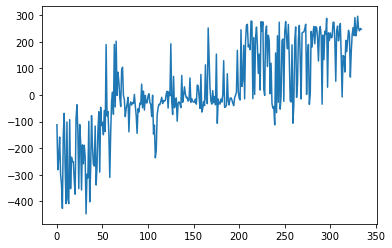

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > 250:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))